# Deep Learning

### Step 1: Download And Extraction

The objective of this project is to train a model that can decode sequences of digits from natural images.
This notebook uses the SVHN dataset collected from house numbers in Google Street View. This dataset consists of digits that are not neatly lined-up and have various skews, fonts and colors, which means we have to do some hyperparameter exploration to do well.

In [18]:
# Import required modules
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# DOWNLOAD DATA

First, we'll download the dataset to our local machine. 

- 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.
- 73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data
- Comes in two formats:
    1. Original images with character level bounding boxes.
    2. MNIST-like 32-by-32 images centered around a single character (many of the images do contain some distractors at the sides).

In [19]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')    
  statinfo = os.stat(filename)
  if statinfo.st_size > 0:
    print ('File found: ', filename)  
  
  return filename

train_filename = maybe_download('train.tar.gz')
test_filename = maybe_download('test.tar.gz')
extra_filename = maybe_download('extra.tar.gz')

File found:  train.tar.gz
File found:  test.tar.gz
File found:  extra.tar.gz


Extracting the dataset from the compressed .tar.gz file. This should give you a set of directories, labelled A through J.

In [20]:
num_classes = 0
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  print(root)
  return root
  
train_folder = maybe_extract(train_filename)
test_folder = maybe_extract(test_filename)
extra_folder = maybe_extract(extra_filename)

train already present - Skipping extraction of train.tar.gz.
train
test already present - Skipping extraction of test.tar.gz.
test
extra already present - Skipping extraction of extra.tar.gz.
extra


# PROCESS BOUNDING BOXES

Each tar.gz file contains the orignal images in png format, together with a digitStruct.mat file (the bounding box information are stored in digitStruct.mat). The digitStruct.mat file contains a struct called digitStruct with the same length as the number of original images. Each element in digitStruct has the following fields: name which is a string containing the filename of the corresponding image (Eg. "2.png"), bbox which is a struct array that contains the position, size and label of each digit bounding box in the image.

The library h5py is used to load the matlab file with this info. Then, the bounding boxes data is loaded to a dictionary which contains all this info ready to be used for preprocessing.

In [21]:
import h5py

def get_data_boxes(h5py_file, start_range, end_range):    
    
    img_list = h5py_file['digitStruct']['name']
    bbox_list = h5py_file['digitStruct']['bbox']
    train_img_box_dict = {}
    
    for i in range(start_range, end_range):
        img_name = h5py_file[img_list[i][0]].value.tostring().replace("\x00","")
        bbox_data = []
        num_points = len(h5py_file[bbox_list[i].item()]["height"])
        if num_points > 1:
            for j in range(num_points):
                box = {}
                box["top"] = h5py_file[h5py_file[bbox_list[i].item()]["top"].value[j].item()].value[0][0]
                box["left"] = h5py_file[h5py_file[bbox_list[i].item()]["left"].value[j].item()].value[0][0]
                box["height"] = h5py_file[h5py_file[bbox_list[i].item()]["height"].value[j].item()].value[0][0]
                box["width"] = h5py_file[h5py_file[bbox_list[i].item()]["width"].value[j].item()].value[0][0]
                box["label"] = h5py_file[h5py_file[bbox_list[i].item()]["label"].value[j].item()].value[0][0]
                bbox_data.append(box)
        else:
            box = {}
            box["top"] = h5py_file[bbox_list[i].item()]["top"].value[0][0]
            box["left"] = h5py_file[bbox_list[i].item()]["left"].value[0][0]
            box["height"] = h5py_file[bbox_list[i].item()]["height"].value[0][0]
            box["width"] = h5py_file[bbox_list[i].item()]["width"].value[0][0]
            box["label"] = h5py_file[bbox_list[i].item()]["label"].value[0][0]            
            bbox_data.append(box)
    
        train_img_box_dict[img_name] = bbox_data    
    
    return train_img_box_dict

In [23]:
train_file = os.path.join(train_folder, 'digitStruct.mat')
train_h5py = h5py.File(train_file, 'r')
train_size = len(train_h5py["digitStruct"]["name"].value)
print(train_size)

33402


In [24]:
train_data_boxes = get_data_boxes(train_h5py, 0, train_size)

In [41]:
test_file = os.path.join(test_folder, 'digitStruct.mat')
test_h5py = h5py.File(test_file, 'r')
test_size = len(test_h5py["digitStruct"]["name"].value)
print(test_size)

13068


In [42]:
test_data_boxes = get_data_boxes(test_h5py, 0, test_size)

In [46]:
extra_file = os.path.join(extra_folder, 'digitStruct.mat')
extra_h5py = h5py.File(extra_file, 'r')
extra_size = len(extra_h5py["digitStruct"]["name"].value)
print(extra_size)

202353


In [47]:
extra_data_boxes = get_data_boxes(extra_h5py, 0, extra_size)

# Before moving on let's take a peek at some of the data to make sure it looks sensible.
- "train_data_boxes.keys()[0]" should give us the key, Eg. "name" of the first digit.
- "train_data_boxes["4833.png"]" should give us the keys and values for all our digit bounding box's for the first image image. 
- And given the name "4833.png" we can then loop through the labels of the image

In [130]:
print(train_data_boxes.keys()[0])

4833.png


In [35]:
print(train_data_boxes["4833.png"])

[{'width': 12.0, 'top': 7.0, 'height': 20.0, 'label': 5.0, 'left': 28.0}, {'width': 8.0, 'top': 7.0, 'height': 20.0, 'label': 2.0, 'left': 40.0}, {'width': 12.0, 'top': 5.0, 'height': 20.0, 'label': 7.0, 'left': 49.0}]


In [37]:
for i in train_data_boxes["4833.png"]:
    print(i["label"])

5.0
2.0
7.0


In [48]:
import PIL.Image as Image

sample_width = 32
sample_heigth = 32

def im2norm(image): 
    '''Normalize images'''
    # Converts image RGB to YUV, calculatin only the Y value 
    # and using it for the gray scale and apply mean subtraction and normalization
    image_norm = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    mean = np.mean(image_norm, dtype='float32')
    std = np.std(image_norm, dtype='float32', ddof=1)
    if std < 1e-4: std = 1.
    image_norm = (image_norm - mean) / std
    return image_norm

def create_datasets(boxes_data, folder):
    X_data = np.zeros(shape=(len(boxes_data), sample_width, sample_heigth, 1), dtype="float32")
    y_data = np.ones(shape=(len(boxes_data),6), dtype="int32") * 10
    sample = 0
    for img_file in boxes_data.keys():
        img_path = os.path.join(folder, img_file)
        img = Image.open(img_path)
        
        top =[]
        left = []
        width = []
        height = []
        label = []
        for i in boxes_data[img_file]:
            top.append(i['top'])
            left.append(i['left'])
            width.append(i['width'])
            height.append(i['height'])
            if i['label'] == 10: label.append(0)
            else: label.append(i['label'])
        
        img_top = np.amin(top)
        img_left = np.amin(left)
        img_width = np.amax(left) + width[np.argmax(left)] - img_left
        img_height = np.amax(top) + height[np.argmax(top)] - img_top
                
        img_top = np.amax([np.ceil(img_top - 0.1*img_height),0]).astype(int)
        img_left = np.amax([np.ceil(img_left - 0.1*img_width),0]).astype(int)
        img_bottom = np.amin([np.floor(img_top + 1.2*img_height),img.size[1]]).astype(int)
        img_right = np.amin([np.floor(img_left + 1.2*img_width),img.size[0]]).astype(int)
        
        img = img.crop((img_left, img_top, img_right, img_bottom)
                      ).resize([sample_width, sample_heigth], Image.ANTIALIAS)
        
        img = im2norm(img) # convert to gray (RGB to YUV and use Y channel), and do mean subtraction and normalization
        
        
        X_data[sample,:,:,:] = img[:,:,:]
        
        digit_count = len(label)
           
        y_data[sample,0] = digit_count
        for i in range(digit_count):
            if i < 5:
                y_data[sample,i+1] = label[i]
            else:  print ('Image with more than 5 digits:',img_file, sample)
                
        sample += 1                
    
    return X_data, y_data

In [43]:
X_train, y_train = create_datasets(train_data_boxes, train_folder)
X_test, y_test = create_datasets(test_data_boxes, test_folder)

print ('Train sizes:', X_train.shape, y_train.shape)
print ('Test sizes:', X_test.shape, y_test.shape)

Image with more than 5 digits: 29930.png 4396
Train sizes: (33402, 32, 32, 1) (33402, 6)
Test sizes: (13068, 32, 32, 1) (13068, 6)


In [133]:
X_train = np.delete(X_train, 4396, axis=0)
y_train = np.delete(y_train, 4396, axis=0)

print ('Train sizes:', X_train.shape, y_train.shape)
print ('Test sizes:', X_test.shape, y_test.shape)

Train sizes: (33401, 32, 32, 1) (33401, 6)
Test sizes: (13068, 32, 32, 1) (13068, 6)


In [134]:
X_extra, y_extra = create_datasets(extra_data_boxes, extra_folder)

print ('Extra sizes:', X_extra.shape, y_extra.shape)

Extra sizes: (202353, 32, 32, 1) (202353, 6)


# Save the data for later reuse

Now that images are preprocessed we can generate and save the datasets for training, testing and extra in a pickle file.

In [135]:
pickle_file = "./pickles/SVHN_train-test-extra_norm.pickle"

try:
    f = open(pickle_file, 'wb')
    save = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'X_extra': X_extra,
        'y_extra': y_extra,  
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print ('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed file size:', statinfo.st_size)

Compressed file size: 1025147133


Also we can create a validation dataset for hyperparameter tuning.

In [136]:
pickle_file = "./pickles/SVHN_train-test-extra_norm.pickle"

with open(pickle_file, 'rb') as f:
  load = pickle.load(f)
  X_train = load['X_train']
  y_train = load['y_train']
  X_test = load['X_test']
  y_test = load['y_test']
  X_extra = load['X_extra']
  y_extra = load['y_extra']
  del load

print('Training set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)
print('Extra set', X_extra.shape, y_extra.shape)

Training set (33401, 32, 32, 1) (33401, 6)
Test set (13068, 32, 32, 1) (13068, 6)
Extra set (202353, 32, 32, 1) (202353, 6)


In [137]:
import random

random.seed()

n_labels = 10

valid_extra_index = [] # from X_extra

for i in np.arange(n_labels):
    if i == 0:
        valid_extra_index.extend(np.where(y_extra[:,1] == (i))[0][:100].tolist())
    else:
        valid_extra_index.extend(np.where(y_extra[:,1] == (i))[0][:600].tolist())

# let's shuffle the letters to have random validation and training set        
random.shuffle(valid_extra_index)

X_valid = X_extra[valid_extra_index,:,:,:]
y_valid = y_extra[valid_extra_index,:]

print('Training:',X_train.shape, y_train.shape)
print('Validation:',X_valid.shape, y_valid.shape)
print('Testing:',X_test.shape, y_test.shape)

Training: (33401, 32, 32, 1) (33401, 6)
Validation: (5500, 32, 32, 1) (5500, 6)
Testing: (13068, 32, 32, 1) (13068, 6)


# DISPLAY SOME IMAGES

Finally, I'll displaying a sample of the labels and images from the dataset using matplotlib.pyplot.

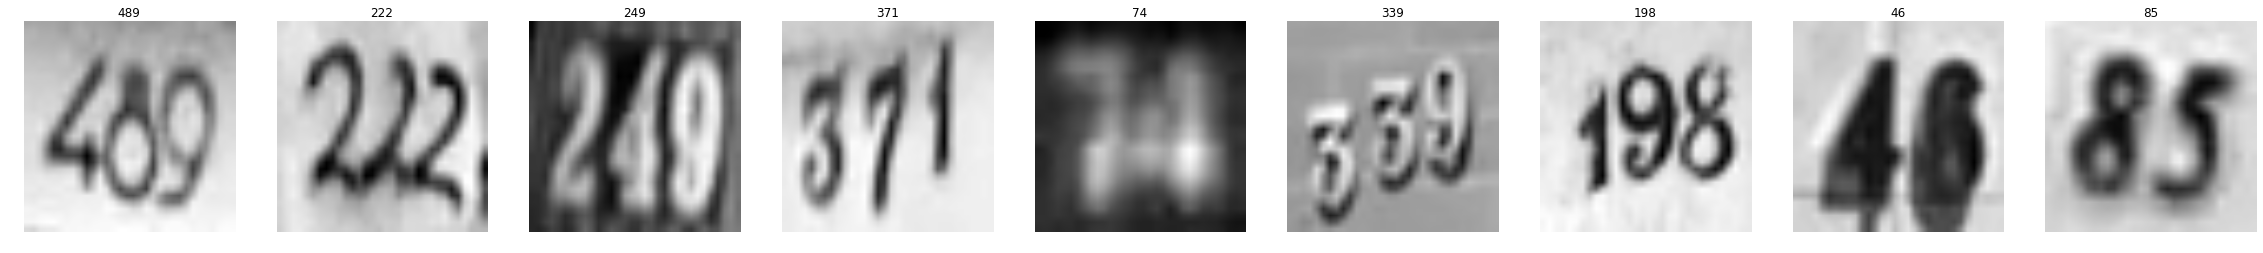

In [138]:
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (40.0, 40.0)
f, ax = plt.subplots(nrows=1, ncols=9)

im_samples = []
    
for i, j in enumerate(np.sort(np.random.randint(0, y_valid.shape[0], size=9))):
    house_num = ''
    for k in np.arange(y_valid[j,0]):
        num = y_valid[j,k+1]
        house_num += str(num)
    im_samples.extend([j])
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(X_valid[j,:,:,0], cmap='gray')

In [139]:
pickle_file = "./pickles/SVHN_train-valid-test_norm_noextra.pickle"

try:
  f = open(pickle_file, 'wb')
  save = {
    'X_train': X_train,
    'y_train': y_train,        
    'X_valid': X_valid,
    'y_valid': y_valid,
    'X_test': X_test,
    'y_test': y_test,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print ('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed file size:', statinfo.st_size)

Compressed file size: 214112769
